In [2]:
import numpy as np
import pandas as pd
import itertools
import plotly.plotly as py
import plotly.graph_objs as go
import seaborn as sns
import matplotlib.pylab as plt
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn import tree
from sklearn.ensemble import BaggingClassifier
from sklearn import metrics
%matplotlib inline

In [3]:
import plotly 
plotly.tools.set_credentials_file(username='anikamal', api_key='BSWmdlJFrie24url3SK4')

In [4]:
df = pd.read_csv("data\\prescriber-info.csv")
# load the file as pandas dataframe
opiate_df = pd.read_csv("data\\opioids.csv")
# read the opiate drug file

# Dropping of drugs that are opiate

In [3]:
opiate = []
for col in opiate_df:
    for drug in opiate_df[col]:
        drug = drug.replace(" ", ".")
        drug = drug.replace("-", ".")
        for given in df.columns:
            if drug == given:
                opiate.append(given)
opiate = list(set(opiate))
df.drop(opiate, axis = 1, inplace = True)
df.head(5)

,NPI,Gender,State,Credentials,Specialty,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,1710982582,M,TX,DDS,Dentist,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1245278100,F,AL,MD,General Surgery,0,0,0,0,0,...,0,0,0,0,0,0,0,0,35,1
2,1427182161,F,NY,M.D.,General Practice,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,1669567541,M,AZ,MD,Internal Medicine,0,0,0,0,21,...,0,0,0,0,0,0,0,0,0,1
4,1679650949,M,NV,M.D.,Hematology/Oncology,0,0,0,0,0,...,0,0,0,0,17,28,0,0,0,1


# User defined functions

In [4]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
def performance_metrics(actual, predict):
    """
    This function evaluates the performance metrics 
    needed.
    """
    
    accuracy = np.mean(actual == predict)
    # compute accuracy
    print("Accuracy: {0}%".format(accuracy*100))
    print("\nReport")
    print(metrics.classification_report(actual, predict))
    # classification report
    matrix = (metrics.confusion_matrix(actual, predict))
    plot_confusion_matrix(matrix, ['0', '1'])
    # plot the confusion matrix
    fpr, tpr, threshold = metrics.roc_curve(actual, predict)
    # values to plot ROC curve
    print("FPR")
    print(fpr)
    print("TPR")
    print(tpr)
    print("Thresholds")
    print(threshold)
    auc = round(metrics.roc_auc_score(actual, predict), 2)
    # get the area under curve
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0})'.format(auc), color = 'green')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

In [47]:
def feature_graph(x, y, k = 10, filename = None):
    """
    Helps to plot the feature and its score
    """

    trace = go.Bar(
                   x = [i[0] for i in feature_imp[:k]],
                   y = [i[1] for i in feature_imp[:k]],
                   )
    data = [trace]
    layout = go.Layout(
        title='Top ten feature-scores',
        xaxis=dict(
            title = "Features",
            tickangle = 40,
            tickfont=dict(
                size=8,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        yaxis=dict(
            title='Feature score',
            titlefont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            ),
            tickfont=dict(
                size=14,
                color='rgba(0, 0, 0, 1)'
            )
        ),
        plot_bgcolor = 'rgba(100, 100, 100, 0.04)'
    )
    
    fig = go.Figure(data=data, layout = layout)
    return py.iplot(fig, filename = filename)

# Down sampling of data

In [7]:
zero = df[df['Opioid.Prescriber'] == 0]
one = df[df['Opioid.Prescriber'] == 1]
# get the data of each class
if len(one) > len(zero):
    index = one.index[len(zero):]
else:
    index = zero.index[:len(one)]

df.drop(index, inplace = True)
# drop the rows to achieve balanced class labels

# Data PreProcessing

In [8]:
gender = df['Gender']
state = df['State']
specialty = df['Specialty']
columns = ['NPI', 'Credentials', 'Gender', 'State', 'Specialty']
# columns to be dropped
df.drop(labels = columns, axis = 1, inplace = True)
# drop the columns
df.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE,Opioid.Prescriber
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,35,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,25,0
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,17,28,0,0,0,1


In [9]:
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features

# Feature Engineering

In [10]:
features.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,17,28,0,0,0


# Eliminate features based on variance

In [11]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
xt = vt.fit_transform(features.values)
variances = vt.variances_

In [12]:
thresholds = np.percentile(variances, [1, 10, 20, 30, 40, 50])
# various thresholds to be tested on

In [13]:
depths = [i for i in range(1, 50, 5)]
# various depths to explore with

In [14]:
cv = ShuffleSplit(n_splits=5, test_size=0.4, random_state=0)
# define how data is to be splitted for CV

In [15]:
vt = VarianceThreshold(threshold = 0)
# initialize the variance
pipe = Pipeline([("vt", vt), ("tree", tree.DecisionTreeClassifier(criterion = "entropy"))])
# pipeline to work
params = {"vt__threshold":thresholds, "tree__max_depth":depths}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'tree__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46], 'vt__threshold': array([  14.56242,   31.89763,   57.22553,   84.06396,  120.60706,
        184.98242])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [16]:
cv_results = clf.cv_results_

In [17]:
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's
            

In [18]:
tree_depth, test_threshold, acc = [], [], []
for each in results_dict.items():
    tree_depth.append(each[0][0][-1])
    test_threshold.append(each[0][1][-1])
    acc.append(each[1])
    
result_df = pd.DataFrame()
result_df['Depth'] = tree_depth
result_df['Threshold'] = test_threshold
result_df['accuracy'] = acc

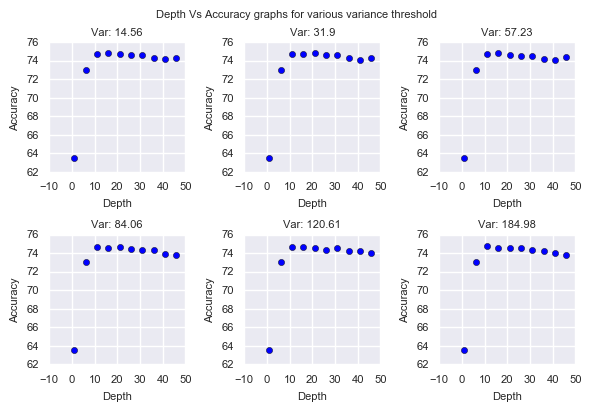

In [22]:
plt.figure(figsize = (6,4))
unique_threshold = sorted(result_df['Threshold'].unique())
for i in range(len(unique_threshold)):
    # iterate over each unique threshold
    data = result_df[result_df['Threshold'] == unique_threshold[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['Depth'], data['accuracy'])
    plt.title("Var: "+str(round(unique_threshold[i], 2)), fontsize = 8)
    plt.xlabel("Depth", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("Depth Vs Accuracy graphs for various variance threshold", fontsize = 8, y = 1.01)
#sns.lmplot('Depth', 'accuracy', hue = 'Threshold', data = result_df, fit_reg=False,palette=sns.color_palette("Blues"))

In [23]:
print("Best variance threshold")
print(clf.best_params_)

Best variance threshold
{'tree__max_depth': 11, 'vt__threshold': 184.98241742571639}


In [24]:
feature_variance_dict = sorted(zip(features.columns, variances), key = lambda x : x[1], reverse = True)
# get the feature variance dict
new_features = [f[0] for f in feature_variance_dict if f[1] > clf.best_params_['vt__threshold']]
# get the new features

## Update feature space

In [25]:
features = features[new_features]
# udpate the feature space
print(len(features.columns))
features.head()

119


,LEVOTHYROXINE.SODIUM,AMLODIPINE.BESYLATE,LISINOPRIL,SIMVASTATIN,OMEPRAZOLE,ATORVASTATIN.CALCIUM,FUROSEMIDE,WARFARIN.SODIUM,METFORMIN.HCL,METOPROLOL.TARTRATE,...,TOPIRAMATE,SULFAMETHOXAZOLE.TRIMETHOPRIM,BUSPIRONE.HCL,AMITRIPTYLINE.HCL,AMIODARONE.HCL,LEVOFLOXACIN,NIFEDIPINE.ER,KLOR.CON.M20,CYCLOBENZAPRINE.HCL,NAPROXEN
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,15,52,51,85,0,0,0,39,18,...,0,0,15,0,0,0,0,0,22,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,58,110,80,52,13,48,0,57,55,...,0,0,0,0,0,0,0,0,12,0
4,0,0,0,0,0,0,0,17,0,0,...,0,14,0,19,0,0,0,0,0,0


# Top K feature selection using chi-square test

In [29]:
top_k_features = list(np.linspace(20, len(features.columns), 6))
# top k features that we would like to get
top_k_features = [int(i) for i in top_k_features]
top_k_features

[20, 39, 59, 79, 99, 119]

In [30]:
top_k = SelectKBest(score_func = chi2, k = 1)
# method to get the top-k features using chi2 test
pipe = Pipeline([("topk", top_k), ("tree", tree.DecisionTreeClassifier(criterion = "entropy"))])
# pipeline to work
params = {"topk__k":top_k_features, "tree__max_depth":depths}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('topk', SelectKBest(k=1, score_func=<function chi2 at 0x0000026586306730>)), ('tree', DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'tree__max_depth': [1, 6, 11, 16, 21, 26, 31, 36, 41, 46], 'topk__k': [20, 39, 59, 79, 99, 119]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [31]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's

In [32]:
tree_depth, test_top_k, acc = [], [], []
for each in results_dict.items():
    #print(each)
    tree_depth.append(each[0][1][-1])
    test_top_k.append(each[0][0][-1])
    acc.append(each[1])
    
result_df = pd.DataFrame()
result_df['depth'] = tree_depth
result_df['top_k'] = test_top_k
result_df['accuracy'] = acc

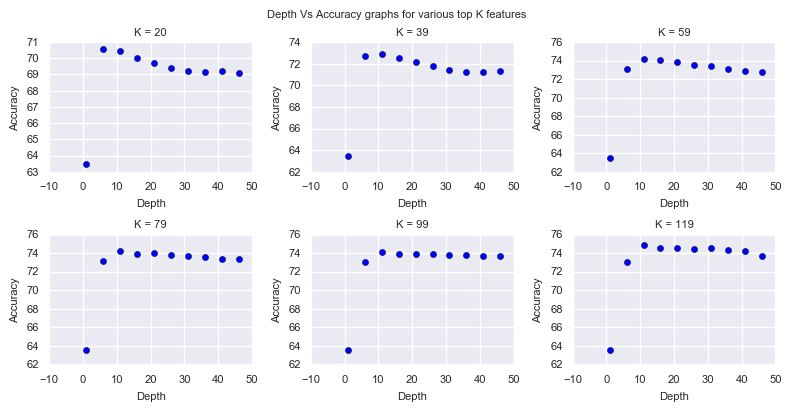

In [34]:
plt.figure(figsize = (8,4))
unique_val = sorted(result_df['top_k'].unique())

for i in range(len(unique_val)):
    # iterate over each unique threshold
    data = result_df[result_df['top_k'] == unique_val[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['depth'], data['accuracy'])
    plt.title("K = " + str(round(unique_val[i])), fontsize = 8)
    plt.xlabel("Depth", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("Depth Vs Accuracy graphs for various top K features", fontsize = 8, y = 1.01)
#sns.lmplot('Depth', 'accuracy', hue = 'Threshold', data = result_df, fit_reg=False,palette=sns.color_palette("Blues"))

In [35]:
print("Best Parameters")
print(clf.best_params_)

Best Parameters
{'tree__max_depth': 11, 'topk__k': 119}


In [36]:
top_k_clf = SelectKBest(score_func = chi2, k = clf.best_params_['topk__k'])
# selecting top K features
top_k_clf.fit_transform(features.values, labels.values)
# fit the data

array([[ 0,  0,  0, ...,  0,  0,  0],
       [31, 15, 52, ...,  0, 22,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ..., 
       [ 0, 18,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=int64)

In [37]:
feature_k_dict = sorted(zip(features.columns, top_k_clf.scores_), key = lambda x : x[1], reverse = True)
# get the feature variance dict
top_features = [f[0] for f in feature_k_dict][:clf.best_params_['topk__k']]
# get the top K features

In [38]:
features = features[top_features]
# updating the feature space
features.head()

,LEVOTHYROXINE.SODIUM,SIMVASTATIN,AMLODIPINE.BESYLATE,LISINOPRIL,OMEPRAZOLE,METFORMIN.HCL,GABAPENTIN,FUROSEMIDE,ATORVASTATIN.CALCIUM,HYDROCHLOROTHIAZIDE,...,OLANZAPINE,DIVALPROEX.SODIUM.ER,RISPERIDONE,DIVALPROEX.SODIUM,XARELTO,BUSPIRONE.HCL,AMIODARONE.HCL,QUETIAPINE.FUMARATE,BUPROPION.XL,KETOCONAZOLE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,51,15,52,85,39,63,0,0,36,...,0,0,0,0,0,15,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,42,0
3,0,80,58,110,52,57,81,48,13,34,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,28,0,0,0,0,0


# Decision Tree Model

## Validation curve

In [39]:
train_scores, test_scores = validation_curve(tree.DecisionTreeClassifier(criterion="entropy"), features.values,
                                            labels.values, param_name = "max_depth", param_range  = np.linspace(1, 50, num = 50),
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

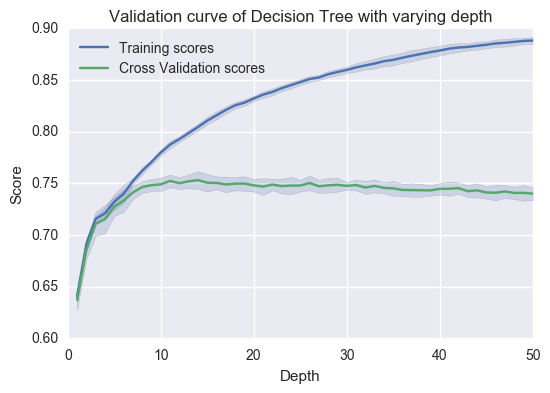

In [40]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(np.linspace(1, 50, num = 50), train_score_mean, label = "Training scores")
plt.plot(np.linspace(1, 50, num = 50), test_score_mean, label = "Cross Validation scores")
plt.fill_between(np.linspace(1, 50, num = 50), train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(np.linspace(1, 50, num = 50), test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with varying depth")
plt.xlabel("Depth")
plt.ylabel("Score")

## Learning curve

In [41]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(tree.DecisionTreeClassifier(criterion="entropy", max_depth=11),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

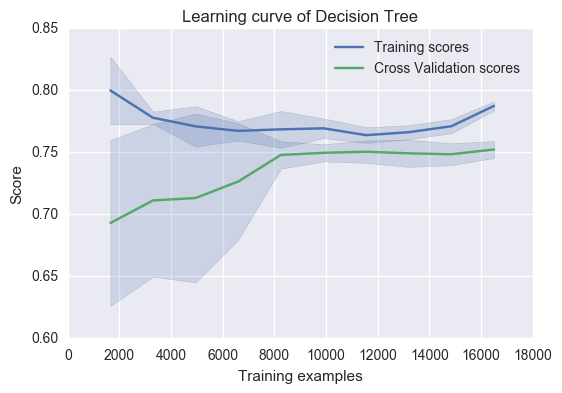

In [42]:
train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Decision Tree")
plt.xlabel("Training examples")
plt.ylabel("Score")

In [43]:
best_clf = tree.DecisionTreeClassifier(criterion = "entropy", max_depth=clf.best_params_['tree__max_depth'])
# final best decision tree model
best_clf.fit(features.values, labels.values)
# fit data to classifier

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=11,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [44]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

# Performance metrics

Accuracy: 75.22788983708301%

Report
             precision    recall  f1-score   support

          0       0.71      0.87      0.78     10312
          1       0.83      0.64      0.72     10312

avg / total       0.77      0.75      0.75     20624

Confusion matrix, without normalization
[[8924 1388]
 [3721 6591]]
FPR
[ 0.          0.13460047  1.        ]
TPR
[ 0.          0.63915826  1.        ]
Thresholds
[2 1 0]


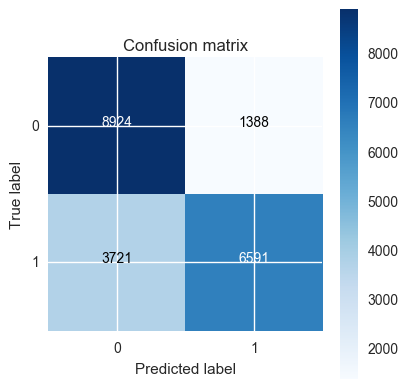

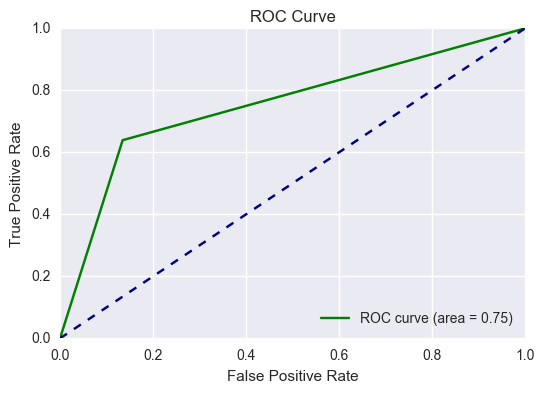

In [45]:
performance_metrics(labels, predict)
# function call to report performance metrics

# Top 10 features

In [48]:
feature_dict = dict(zip(features.columns, best_clf.feature_importances_))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-tree-with-feature-engg")
# plot the data

# Bagging wrapped with Decision Tree

In [49]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['tree__max_depth']))

param_range = list(range(1, 12, 5))
bag_train_scores, bag_test_scores = validation_curve(bagging_classifier, features.values,
                                            labels.values, param_name = "n_estimators", param_range  = param_range,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

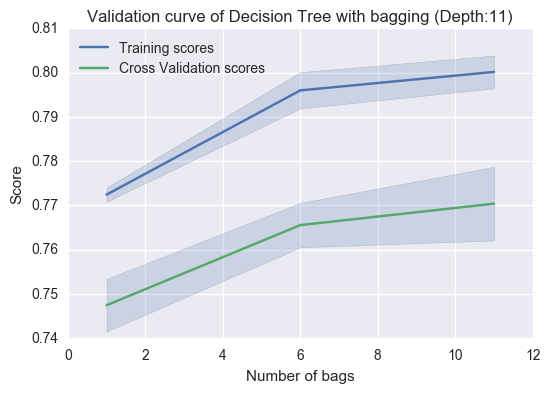

In [50]:
train_score_mean = np.mean(bag_train_scores, axis = 1)
train_score_std = np.std(bag_train_scores, axis = 1)
test_score_mean = np.mean(bag_test_scores, axis = 1)
test_score_std = np.std(bag_test_scores, axis = 1)

plt.plot(param_range, train_score_mean, label = "Training scores")
plt.plot(param_range, test_score_mean, label = "Cross Validation scores")
plt.fill_between(param_range, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(param_range, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Decision Tree with bagging (Depth:{0})".format(clf.best_params_['tree__max_depth']))
plt.xlabel("Number of bags")
plt.ylabel("Score")

In [ ]:
bagging_classifier = BaggingClassifier(tree.DecisionTreeClassifier(criterion="entropy", max_depth=clf.best_params_['tree__max_depth']), n_estimators = 6)
# bagging classifier
bagging_classifier.fit(features.values, labels.values)

# Logistic Regression

In [52]:
from sklearn import linear_model
labels = df['Opioid.Prescriber']
# get the class label values
features = df.drop(labels = 'Opioid.Prescriber', axis = 1)
# features for the data
features = pd.get_dummies(features)
# convert categorical data as features
features.head()

,ABILIFY,ACYCLOVIR,ADVAIR.DISKUS,AGGRENOX,ALENDRONATE.SODIUM,ALLOPURINOL,ALPRAZOLAM,AMIODARONE.HCL,AMITRIPTYLINE.HCL,AMLODIPINE.BESYLATE,...,VENTOLIN.HFA,VERAPAMIL.ER,VESICARE,VOLTAREN,VYTORIN,WARFARIN.SODIUM,XARELTO,ZETIA,ZIPRASIDONE.HCL,ZOLPIDEM.TARTRATE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,134,0,0,15,...,0,0,0,0,0,0,0,0,0,35
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,25
3,0,0,0,0,21,0,0,0,0,58,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,19,0,...,0,0,0,0,0,17,28,0,0,0


In [53]:
vt = VarianceThreshold()
xt = vt.fit_transform(features.values)
variances = vt.variances_
thresholds = np.percentile(variances, [1, 10, 20, 30, 40, 50])
# various thresholds to be tested on
c_val = [0.001, 0.01, 0.1, 1, 2]
# C values
vt = VarianceThreshold(threshold = 0)
# initialize the variance
pipe = Pipeline([("vt", vt), ("logistic", linear_model.LogisticRegression())])
# pipeline to work
params = {"vt__threshold":thresholds, "logistic__C":c_val}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('vt', VarianceThreshold(threshold=0)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'vt__threshold': array([  14.56242,   31.89763,   57.22553,   84.06396,  120.60706,
        184.98242]), 'logistic__C': [0.001, 0.01, 0.1, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [54]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's
            
c_value, test_threshold, acc = [], [], []
for each in results_dict.items():
    c_value.append(each[0][0][-1])
    test_threshold.append(each[0][1][-1])
    acc.append(each[1])
    
result_df = pd.DataFrame()
result_df['C'] = c_value
result_df['Threshold'] = test_threshold
result_df['accuracy'] = acc

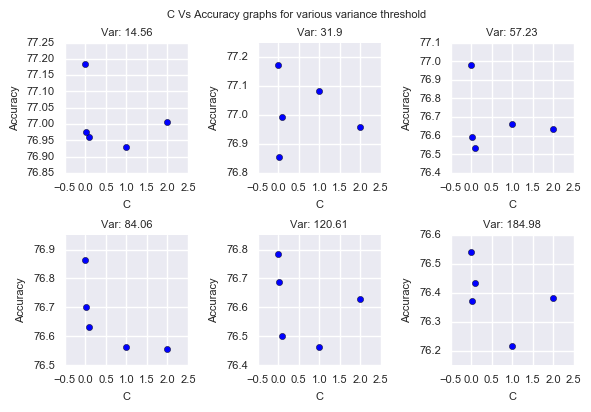

In [55]:
plt.figure(figsize = (6,4))
unique_threshold = sorted(result_df['Threshold'].unique())
for i in range(len(unique_threshold)):
    # iterate over each unique threshold
    data = result_df[result_df['Threshold'] == unique_threshold[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['C'], data['accuracy'])
    plt.title("Var: " + str(round(unique_threshold[i], 2)), fontsize = 8)
    plt.xlabel("C", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("C Vs Accuracy graphs for various variance threshold", fontsize = 8, y = 1.01)

In [56]:
print("Best parameters")
clf.best_params_

Best parameters


{'logistic__C': 0.001, 'vt__threshold': 14.562415700358287}

In [57]:
feature_variance_dict = sorted(zip(features.columns, variances), key = lambda x : x[1], reverse = True)
# get the feature variance dict
new_features = [f[0] for f in feature_variance_dict if f[1] > clf.best_params_['vt__threshold']]
# get the new features
features = features[new_features]
# udpate the feature space
features.head()

,LEVOTHYROXINE.SODIUM,AMLODIPINE.BESYLATE,LISINOPRIL,SIMVASTATIN,OMEPRAZOLE,ATORVASTATIN.CALCIUM,FUROSEMIDE,WARFARIN.SODIUM,METFORMIN.HCL,METOPROLOL.TARTRATE,...,DILTIAZEM.ER,VENLAFAXINE.HCL,TOPROL.XL,VYTORIN,AGGRENOX,SUMATRIPTAN.SUCCINATE,PROPRANOLOL.HCL.ER,FLOVENT.HFA,VALSARTAN,CARTIA.XT
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,15,52,51,85,0,0,0,39,18,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,58,110,80,52,13,48,0,57,55,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,17,0,0,...,0,0,0,0,0,0,0,0,0,0


# Selecting top k features based on chi-square test

In [58]:
top_k_features = list(np.linspace(20, len(features.columns), 6))
top_k_features = [int(i) for i in top_k_features]
print(top_k_features)
# top k features that we would like to get
top_k = SelectKBest(score_func = chi2, k = 1)
# method to get the top-k features using chi2 test
pipe = Pipeline([("topk", top_k), ("logistic", linear_model.LogisticRegression())])
# pipeline to work
c_val = [0.001, 0.01, 0.1, 1, 2]
params = {"topk__k":top_k_features, "logistic__C":c_val}
# parameters to be tested with
clf = GridSearchCV(pipe, param_grid = params, n_jobs=-1, cv = cv, scoring = "accuracy")
# test various parameters on the classifier
clf.fit(features.values, labels.values)
# fit the data

[20, 63, 106, 149, 192, 236]


GridSearchCV(cv=ShuffleSplit(n_splits=5, random_state=0, test_size=0.4, train_size=None),
       error_score='raise',
       estimator=Pipeline(steps=[('topk', SelectKBest(k=1, score_func=<function chi2 at 0x0000026586306730>)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'topk__k': [20, 63, 106, 149, 192, 236], 'logistic__C': [0.001, 0.01, 0.1, 1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [59]:
cv_results = clf.cv_results_
results_dict = {}
# empty dict
for j in range(len(cv_results['params'])):
        # iterate over the index of each parameter
        k = tuple(sorted(cv_results['params'][j].items()))
        # the key to the dict
        results_dict[k] = []
        # empty dict
        for i in range(5):
            # iterate over each CV
            results_dict[k].append(cv_results['split{0}_test_score'.format(i)][j])
            # append score to the dict
        results_dict[k] = np.mean(results_dict[k])*100
        # take the mean of all CV's

c_value, test_top_k, acc = [], [], []
for each in results_dict.items():
    c_value.append(each[0][0][-1])
    test_top_k.append(each[0][1][-1])
    acc.append(each[1])
    
result_df = pd.DataFrame()
result_df['C'] = c_value
result_df['top_k'] = test_top_k
result_df['accuracy'] = acc
result_df.head()

,C,top_k,accuracy
0,2.00,20,69.580606
1,0.01,63,74.792727
2,0.10,63,74.499394
3,0.01,192,76.455758
4,1.00,63,74.707879


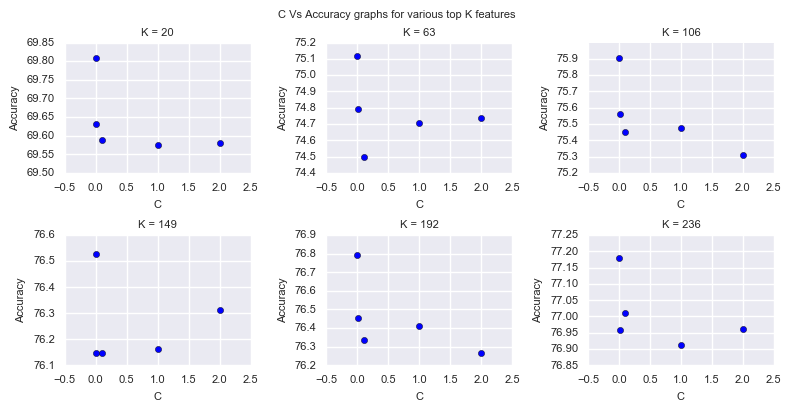

In [61]:
plt.figure(figsize = (8,4))
unique_val = sorted(result_df['top_k'].unique())

for i in range(len(unique_val)):
    # iterate over each unique threshold
    data = result_df[result_df['top_k'] == unique_val[i]]
    plt.subplot(2, 3, i+1)
    plt.scatter(data['C'], data['accuracy'])
    plt.title("K = " + str(round(unique_val[i])), fontsize = 8)
    plt.xlabel("C", fontsize = 8)
    plt.ylabel("Accuracy", fontsize = 8)
    plt.xticks(fontsize = 8)
    plt.yticks(fontsize = 8)
plt.tight_layout()
plt.suptitle("C Vs Accuracy graphs for various top K features", fontsize = 8, y = 1.01)

In [62]:
clf.best_params_

{'logistic__C': 0.001, 'topk__k': 236}

In [63]:
top_k_clf = SelectKBest(score_func = chi2, k = clf.best_params_['topk__k'])
# selecting top K features
top_k_clf.fit_transform(features.values, labels.values)
# fit the data
feature_k_dict = sorted(zip(features.columns, top_k_clf.scores_), key = lambda x : x[1], reverse = True)
# get the feature variance dict
top_features = [f[0] for f in feature_k_dict][:clf.best_params_['topk__k']]
# get the top K features

features = features[top_features]
# updating the feature space
features.head()

,LEVOTHYROXINE.SODIUM,SIMVASTATIN,AMLODIPINE.BESYLATE,LISINOPRIL,OMEPRAZOLE,METFORMIN.HCL,GABAPENTIN,FUROSEMIDE,ATORVASTATIN.CALCIUM,HYDROCHLOROTHIAZIDE,...,QUETIAPINE.FUMARATE,OXCARBAZEPINE,NITROSTAT,METRONIDAZOLE,RANEXA,BUPROPION.XL,KETOCONAZOLE,SOTALOL,AMPHETAMINE.SALT.COMBO,PRADAXA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,31,51,15,52,85,39,63,0,0,36,...,0,0,0,0,0,0,0,0,0,13
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,42,0,0,0,0
3,0,80,58,110,52,57,81,48,13,34,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Validation curve

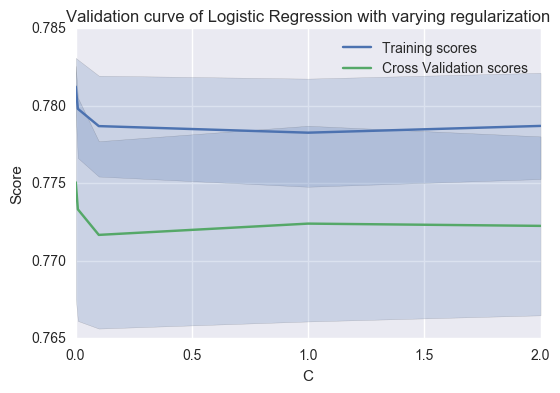

In [66]:
c_val = [0.001, 0.01, 0.1, 1, 2]
train_scores, test_scores = validation_curve(linear_model.LogisticRegression(), features.values,
                                            labels.values, param_name = "C", param_range  = c_val,
                                            scoring = "accuracy", n_jobs = -1, cv = 5)
# get the validation results for the decision tree across various depths

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(c_val, train_score_mean, label = "Training scores")
plt.plot(c_val, test_score_mean, label = "Cross Validation scores")
plt.fill_between(c_val, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(c_val, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Validation curve of Logistic Regression with varying regularization")
plt.xlabel("C")
plt.ylabel("Score")

# Learning curve

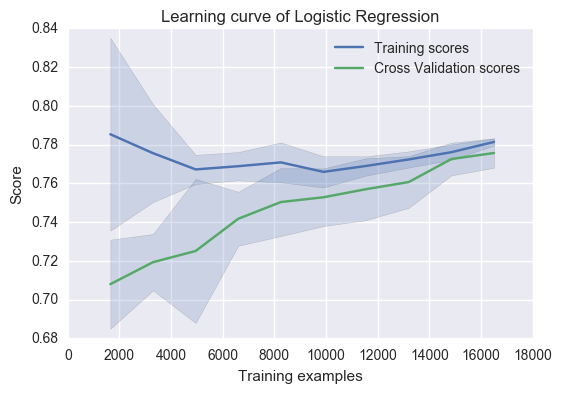

In [67]:
size = np.linspace(0.1, 1, 10)
# the size of train sets
train_sizes, train_scores, test_scores = learning_curve(linear_model.LogisticRegression(C=clf.best_params_['logistic__C']),
                                                   X=features.values, y = labels.values, cv = 5, n_jobs = -1,
                                               train_sizes = size)
# get the learning curve results for the data

train_score_mean = np.mean(train_scores, axis = 1)
train_score_std = np.std(train_scores, axis = 1)
test_score_mean = np.mean(test_scores, axis = 1)
test_score_std = np.std(test_scores, axis = 1)

plt.plot(train_sizes, train_score_mean, label = "Training scores")
plt.plot(train_sizes, test_score_mean, label = "Cross Validation scores")
plt.fill_between(train_sizes, train_score_mean - train_score_std,
                 train_score_mean + train_score_std, alpha=0.2)
plt.fill_between(train_sizes, test_score_mean - test_score_std,
                 test_score_mean + test_score_std, alpha=0.2)
plt.legend(loc="best")
plt.title("Learning curve of Logistic Regression")
plt.xlabel("Training examples")
plt.ylabel("Score")

# Final Logistic Regression Model

In [68]:
best_clf = linear_model.LogisticRegression(C = clf.best_params_['logistic__C'])
# final best decision tree model
best_clf.fit(features.values, labels.values)
# fit data to classifier

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [69]:
predict = cross_val_predict(best_clf, X = features.values, y = labels.values, cv = 5, n_jobs = -1)
# predict class label based on CV

# Performance metrics

Accuracy: 77.50678820791312%

Report
             precision    recall  f1-score   support

          0       0.73      0.88      0.80     10312
          1       0.85      0.67      0.75     10312

avg / total       0.79      0.78      0.77     20624

Confusion matrix, without normalization
[[9060 1252]
 [3387 6925]]
FPR
[ 0.          0.12141195  1.        ]
TPR
[ 0.          0.67154771  1.        ]
Thresholds
[2 1 0]


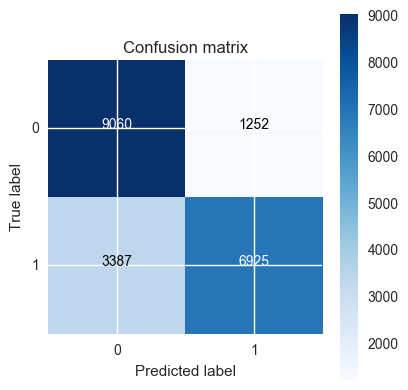

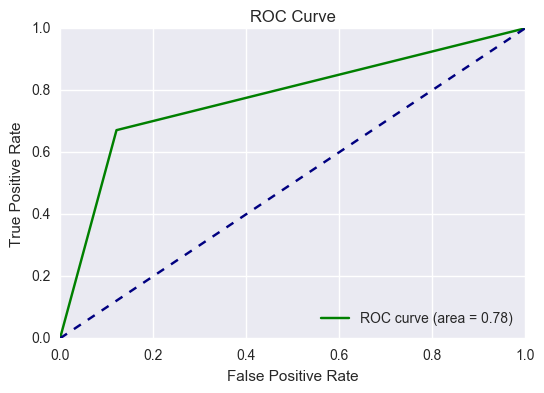

In [70]:
performance_metrics(labels, predict)
# function call to report performance metrics

# Top 10 features

In [71]:
feature_dict = dict(zip(features.columns, best_clf.coef_[0]))
# get the feature and its scores
feature_imp = sorted(feature_dict.items(), key = lambda x : x[1], reverse = True)
# sort based on feature score
x = [i[0] for i in feature_imp]
y = [i[1] for i in feature_imp]
# top 10 features
feature_graph(x, y, filename = "top-10-logistics-with-feature-engg")
# plot the data